# Intro Task, Object Localization 

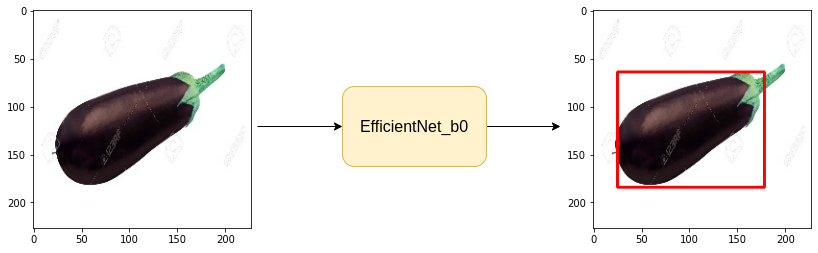

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-_jb7cdq6
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-_jb7cdq6
  Resolved https://github.com/albumentations-team/albumentations to commit 2a1826d49c9442ae28cf33ddef658c8e24505cf8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=124568 sha256=e5a8ed7742f208d2d5f8b84a16711867952965d445d40d80998440b115d9a012
  Stored in directory: /tmp/pip-ephem-wheel-cache-srzi7boz/wheels/f3/4a/7f/67b055656bec4d4aaa8963cfc93678f6f2906b2d72054a1268
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
L

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 2.90 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [28]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'resnet50'

NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

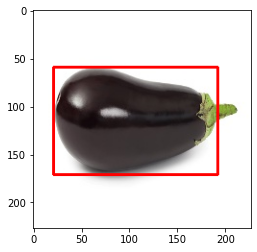

In [7]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2)
plt.imshow(bnd_box_img)

In [8]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [11]:
class ObjLocDataset(torch.utils.data.Dataset):
  
  def __init__(self,df,augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2,0,1)/255.0
    bbox = torch.Tensor(bbox)

    return img, bbox

In [12]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [13]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the validset: 38


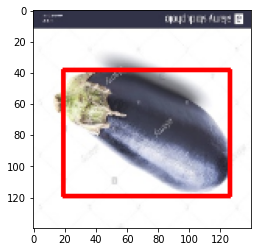

In [14]:
img, bbox = trainset[9]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [18]:
from torch import nn 
import timm

In [19]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)
    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes

In [20]:
model = ObjLocModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

# Create Train and Eval Function

In [21]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [22]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()

  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)
    loss.backward()
    

    total_loss += loss.item()

  return total_loss / len(dataloader)

#Training Loop

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [24]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("WEIGHTS-ARE-SAVED")
    best_valid_loss = valid_loss

  print(f'Epoch : {i + 1} train loss : {train_loss} valid loss : {valid_loss}')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 1 train loss : 5495.1982421875 valid loss : 3273.116455078125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 2 train loss : 2242.0481689453127 valid loss : 1230.2712809244792


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 3 train loss : 1369.4499572753907 valid loss : 257.51206970214844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 train loss : 909.5489501953125 valid loss : 283.462651570638


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 5 train loss : 695.779345703125 valid loss : 204.90087381998697


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 6 train loss : 475.55641174316406 valid loss : 166.23772430419922


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 train loss : 371.76365966796874 valid loss : 257.6570739746094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 train loss : 288.77022247314454 valid loss : 250.77024841308594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 train loss : 216.2787841796875 valid loss : 211.58198038736978


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 10 train loss : 186.5212776184082 valid loss : 127.51116434733073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11 train loss : 132.04951400756835 valid loss : 145.15017700195312


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12 train loss : 139.73928451538086 valid loss : 132.64887237548828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13 train loss : 110.24846267700195 valid loss : 145.78173828125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 14 train loss : 106.12894287109376 valid loss : 117.16224161783855


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15 train loss : 94.31529235839844 valid loss : 130.93321228027344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 train loss : 103.88932456970215 valid loss : 137.70182037353516


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 17 train loss : 96.36306533813476 valid loss : 112.06497446695964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 18 train loss : 81.86468276977538 valid loss : 100.85385131835938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 19 train loss : 91.05539894104004 valid loss : 95.22292582194011


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 20 train loss : 76.1849136352539 valid loss : 75.7074712117513


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 train loss : 59.97208786010742 valid loss : 81.87831370035808


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 train loss : 73.50159492492676 valid loss : 138.9846165974935


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss : 64.38675460815429 valid loss : 88.85375722249348


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 24 train loss : 61.76406059265137 valid loss : 68.65777842203777


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss : 45.459294128417966 valid loss : 72.64911651611328


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 26 train loss : 67.8470085144043 valid loss : 65.46540959676106


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27 train loss : 52.83379898071289 valid loss : 77.24798965454102


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 28 train loss : 40.18923397064209 valid loss : 65.00350697835286


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 train loss : 49.870270538330075 valid loss : 75.11907958984375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 30 train loss : 43.30308380126953 valid loss : 56.75483194986979


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss : 41.30505199432373 valid loss : 59.48309580485026


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss : 38.931115531921385 valid loss : 81.07999928792317


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch : 33 train loss : 45.26666431427002 valid loss : 53.0507558186849


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss : 44.48138694763183 valid loss : 59.79181162516276


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 train loss : 58.10432510375976 valid loss : 77.83102671305339


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss : 38.2399169921875 valid loss : 66.04450988769531


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 train loss : 34.03548793792724 valid loss : 79.00762176513672


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss : 38.70712509155273 valid loss : 79.59038925170898


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 train loss : 33.09976711273193 valid loss : 61.61366271972656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 train loss : 28.809183502197264 valid loss : 62.37453587849935


#Inference

In [25]:
import utils

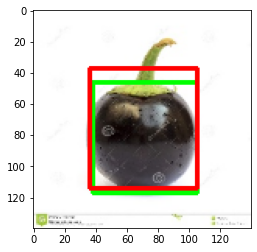

In [29]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

  image, gt_bbox = validset[20]
  image = image.unsqueeze(0).to(DEVICE)
  out_bbox = model(image)
                   
  utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya